# How to use SDFC

## I. Preprocessing
### I.1 Packages

In [1]:
import sys,os
import pickle as pk
import itertools as itt

## Scientific libraries
##=====================
import numpy as np
import scipy.stats as sc

## Plot libraries
##===============
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### I.2 Custom classes

In [2]:
class Object(object):
	pass

### I.3 Custom functions

### I.5 Custom plot functions

In [3]:
def _figsize( nrow , ncol , npix = 5 , ratio = 13 / 9 ):
	return (ratio * ncol * npix , nrow * npix )

In [4]:
def _covariance_ellipse( PX , i = 0 , j = 1 , n_std = 3.0 , facecolor = "none" , **kwargs ):
	
	## Define the figure and axe
	if kwargs.get("ax") is not None:
		fig = kwargs.get("fig") ## Can be None
		ax  = kwargs.get("ax")
	else:
		if kwargs.get("fig") is not None:
			fig = kwargs.get("fig")
		else:
			fs = 1.3
			fig = plt.figure( figsize = (fs * 6,fs * 4) )
		ax = fig.add_subplot( 1 , 1 , 1 )
	
	if kwargs.get("ax") is not None:
		del kwargs["ax"]
	if kwargs.get("fig") is not None:
		del kwargs["fig"]
	
	
	if type(n_std) is not list:
		n_std = [n_std]
	
	if type(PX) == np.ndarray:
		PX = sc.multivariate_normal( mean = PX.mean(0) , cov = np.cov(PX.T) , allow_singular = True )
	
	pearson = PX.cov[i,j] / np.sqrt(PX.cov[i,i] * PX.cov[j,j])
	
	# Using a special case to obtain the eigenvalues of this
	# two-dimensionl dataset.
	ell_radius_x = np.sqrt(1 + pearson)
	ell_radius_y = np.sqrt(1 - pearson)
	scale_x = [np.sqrt(PX.cov[i,i]) * ns for ns in n_std]
	scale_y = [np.sqrt(PX.cov[j,j]) * ns for ns in n_std]

	for k,ns in enumerate(n_std):
		ellipse = mpl.patches.Ellipse( (0, 0) , width = ell_radius_x * 2 , height = ell_radius_y * 2 , facecolor=facecolor , **kwargs )
		
		transf = mpl.transforms.Affine2D() \
			.rotate_deg(45) \
			.scale(scale_x[k], scale_y[k]) \
			.translate(PX.mean[i],PX.mean[j])
		
		ellipse.set_transform(transf + ax.transData)
		ax.add_patch(ellipse)
	
	ax.relim()
	ax.autoscale_view()
	return fig,ax

In [5]:
cplt = Object()
cplt.figsize  = _figsize
cplt.covariance_ellipse = _covariance_ellipse

### I.6 Global parameters

In [10]:
glob = Object()
glob.n_samples = 2500

## II. Introduction

### II.1 Generalities on SDFC

### II.2 Architecture

### II.3 Import SDFC in python

The proposal syntax to import SDFC in python is

In [6]:
import SDFC as sd

### 1.4 Testing dataset
The function `sd.tools.Dataset.covariates` build three covariates and a time axis, usefull to be familiar with the SDFC syntax. The three covariates correspond to the three classical parameters of a distribution: the location, noted $\mu$, the scale, noted $\sigma$ and the shape, noted $\xi$. Three covariates noted $X_\mu$, $X_\sigma$ and $X_\xi$ are returned:

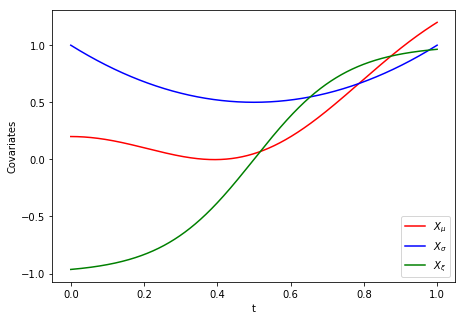

In [11]:
t,X_loc,X_scale,X_shape = sd.tools.Dataset.covariates(glob.n_samples)

fig = plt.figure( figsize = cplt.figsize(1,1) )
ax  = fig.add_subplot(1,1,1)
ax.plot( t , X_loc   , color = "red"   , linestyle = "-" , label = r"$X_\mu$" )
ax.plot( t , X_scale , color = "blue"  , linestyle = "-" , label = r"$X_\sigma$" )
ax.plot( t , X_shape , color = "green" , linestyle = "-" , label = r"$X_\xi$" )
ax.set_xlabel( "t" )
ax.set_ylabel( "Covariates" )
ax.legend()
plt.show()

## III. Parametric Statistical laws

### III.1 Abstract Law : template of all laws

### III.2 Generic way to fit a parametric law, example with a Normal distribution

We start by define a dataset $Y$, from a Normal law $\mathcal{N}(\mu_t,\sigma_t)$, with:

$$
\begin{aligned}
\mu_t    &=    \mu_0 + \mu_1    X_\mu \\
\sigma_t &= \sigma_0 + \sigma_1 X_\sigma
\end{aligned}
$$

Our goal is to regress the parameters $\mu_0$, $\mu_1$, $\sigma_0$ and $\sigma_1$. Start by drawing realisations of the random variable $Y\sim\mathcal{N}(\mu_t,\sigma_t)$

In [16]:
loc   = 0.2 + 0.8 * X_loc
scale = 0.1 + 0.5 * X_scale
Y     = np.random.normal( loc = loc , scale = scale , size = glob.n_samples )

A fit using the maximum likelihood estimator is performed, with $100$ bootstrap. The keywords `c_loc` and `c_scale` define the two covariates of `loc` ($\mu$) and `scale` ($\sigma$) parameters. Print the law print a summary of coefficients fitted.

In [17]:
law_norm = sd.Normal( method = "MLE" , n_bootstrap = 100 )
law_norm.fit( Y , c_loc = X_loc , c_scale = X_scale )
print(law_norm)

+--------------+--------+-----------+----------------+----------------+----------------+
| Normal (mle) |  Link  |   Type    |      coef      | Quantile 0.025 | Quantile 0.975 |
+==============+========+===========+================+================+================+
| loc          | IdLink | Covariate | [0.201, 0.81]  | [0.185, 0.762] | [0.219, 0.862] |
+--------------+--------+-----------+----------------+----------------+----------------+
| scale        | IdLink | Covariate | [0.086, 0.502] | [0.037, 0.402] | [0.147, 0.584] |
+--------------+--------+-----------+----------------+----------------+----------------+



We can see the quality of the fit with a visual check:

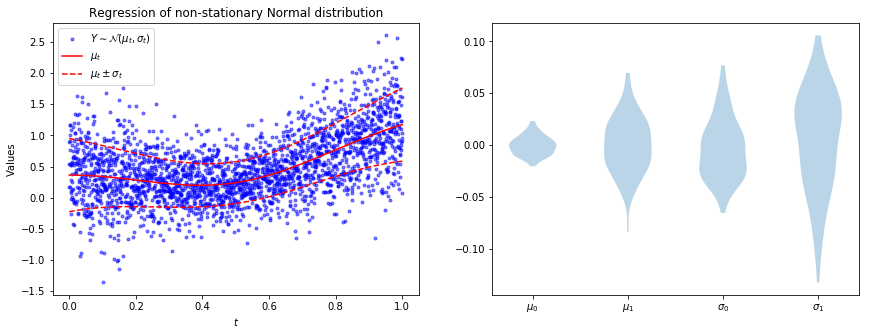

In [48]:
nrow,ncol = 1,2
fig = plt.figure( figsize = cplt.figsize(nrow,ncol) )

ax = fig.add_subplot( nrow , ncol , 1 )
ax.plot( t , Y , color = "blue" , linestyle = "" , marker = "." , alpha = 0.5 , label = r"$Y\sim\mathcal{N}(\mu_t,\sigma_t)$" )
ax.plot( t , law_norm.loc , color = "red" , linestyle = "-" , marker = "" , label = r"$\mu_t$" )
ax.plot( t , law_norm.loc + law_norm.scale , color = "red" , linestyle = "--" , marker = "" , label = r"$\mu_t\pm\sigma_t$" )
ax.plot( t , law_norm.loc - law_norm.scale , color = "red" , linestyle = "--" , marker = "" )
ax.set_xlabel( r"$t$" )
ax.set_ylabel( "Values" )
ax.set_title( "Regression of non-stationary Normal distribution" )
ax.legend()

ax = fig.add_subplot( nrow , ncol , 2 )
ax.violinplot( law_norm.coefs_bootstrap - law_norm.coef_ , showextrema = False )
ax.set_xticks([1,2,3,4])
ax.set_xticklabels([r"$\mu_0$",r"$\mu_1$",r"$\sigma_0$",r"$\sigma_1$"])

#sd.tools.plot_confidences_intervals( law_norm , ax )

plt.show()

If $\mu$ (or $\sigma$) are already known, you can pass it as fix parameter with the syntax `f_<param>`. Here we propose first to fix the `loc` parameter, and second to fix the `scale` parameter.

In [14]:
law_norm_fl = sd.Normal() ## Fit with fix loc
law_norm_fl.fit( Y , f_loc = loc , c_scale = X1 )
law_norm_fsc = sd.Normal() ## Fit with fix scale
law_norm_fsc.fit( Y , c_loc = X0 , f_scale = scale )
print(law_norm_fl)
print(law_norm_fsc)

+--------------+--------+-----------+------------+
| Normal (mle) |  Link  |   Type    |    coef    |
+==============+========+===========+============+
| loc          | IdLink | Fix       | None       |
+--------------+--------+-----------+------------+
| scale        | IdLink | Covariate | [0.0, 0.1] |
+--------------+--------+-----------+------------+

+--------------+--------+-----------+----------------+
| Normal (mle) |  Link  |   Type    |      coef      |
+==============+========+===========+================+
| loc          | IdLink | Covariate | [0.199, 0.803] |
+--------------+--------+-----------+----------------+
| scale        | IdLink | Fix       | None           |
+--------------+--------+-----------+----------------+



Sometimes, it can be useful to pass a link function to a parameter. For example, to ensure the positivity of the scale we can assume that:
$\sigma_t = \exp(\sigma_0+\sigma_1 X_1)$
It is easy with the generic keyword `l_<param>`.

In [16]:
law_norm_lf = sd.Normal()
law_norm_lf.fit( Y , c_loc = X0 , c_scale = X1 , l_scale = sdt.ExpLink() )
print(law_norm_lf)

+--------------+--------------+-----------+-----------------+
| Normal (mle) |     Link     |   Type    |      coef       |
+==============+==============+===========+=================+
| loc          | IdLink       | Covariate | [0.199, 0.801]  |
+--------------+--------------+-----------+-----------------+
| scale        | ExpLink (>0) | Covariate | [-4.266, 2.081] |
+--------------+--------------+-----------+-----------------+



Finnaly, we plot the dataset, the parameters fitted, and the confidence interval

<IPython.core.display.Javascript object>


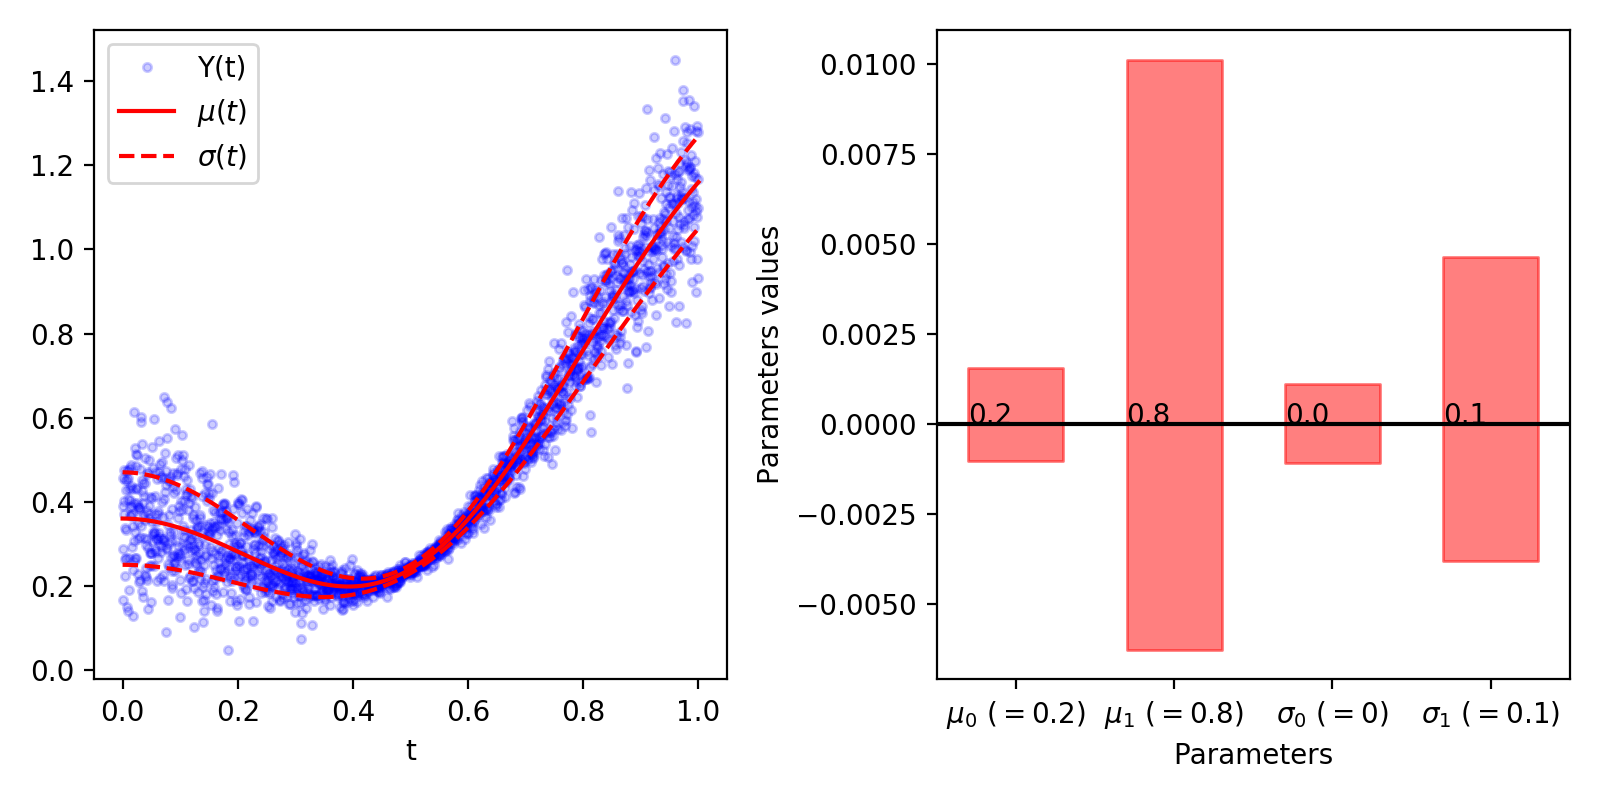

In [15]:
nrow,ncol = 1,2
fig = plt.figure( figsize = (8,4) )

ax = fig.add_subplot( nrow , ncol , 1 )
ax.plot( t , Y , color = "blue" , linestyle = "" , marker = "." , alpha = 0.2 , label = "Y(t)" )
ax.plot( t , loc , color = "red" , linestyle = "-" , label = r"$\mu(t)$" )
ax.plot( t , loc + scale , color = "red" , linestyle = "--" , label = r"$\sigma(t)$" )
ax.plot( t , loc - scale , color = "red" , linestyle = "--" )
ax.set_xlabel("t")
ax.legend( loc = "upper left")

ax = fig.add_subplot( nrow , ncol , 2 )
ax = sdt.plot_confidences_intervals( law_norm , ax )
ax.set_xticklabels( [r"$\mu_0\ (=0.2)$",r"$\mu_1\ (=0.8)$",r"$\sigma_0\ (=0)$",r"$\sigma_1\ (=0.1)$"] )

fig.set_tight_layout(True)
fig.show()

### III.3 Example with the GEV distribution

## IV. Non Parametric Statistics

### IV.1 Classic statistics (mean, variance, etc)

### IV.2 Quantile Regression

## V. Useful tools

### V.1 Link Function

### V.2 Plot confidence interval of parameters